In [ ]:
import numpy as np
from PIL import Image

from keras.layers import merge, Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam
import os
from keras.backend import binary_crossentropy
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
smooth = 1e-12

In [ ]:
import tensorflow as tf
import keras

backend = tf

def focal(alpha=0.25, gamma=5.0):
    def _focal(y_true, y_pred):
        labels         = y_true
        classification = y_pred

        # compute the focal loss
        alpha_factor = keras.backend.ones_like(labels) * alpha
        alpha_factor = backend.where(keras.backend.equal(labels, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = backend.where(keras.backend.equal(labels, 1), 1 - classification, classification)
        focal_weight = alpha_factor * focal_weight ** gamma

        cls_loss = focal_weight * keras.backend.binary_crossentropy(labels, classification)

#         # filter out "ignore" anchors
#         anchor_state = keras.backend.max(labels, axis=2)  # -1 for ignore, 0 for background, 1 for object
#         indices      = backend.where(keras.backend.not_equal(anchor_state, -1))
#         cls_loss     = backend.gather_nd(cls_loss, indices)

#         # compute the normalizer: the number of positive anchors
#         normalizer = backend.where(keras.backend.equal(anchor_state, 1))
#         normalizer = keras.backend.cast(keras.backend.shape(normalizer)[0], keras.backend.floatx())
#         normalizer = keras.backend.maximum(1.0, normalizer)

#         return keras.backend.sum(cls_loss) / normalizer
        return cls_loss

    return _focal

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [ ]:
import keras.backend as K

In [ ]:
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)

In [ ]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

In [ ]:
def get_unet(num_channels, img_rows, img_cols):
    
    inputs = Input((img_rows, img_cols, num_channels))
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(inputs)
    conv1 = BatchNormalization()(conv1)
#     conv1 = BatchNormalization(mode=0, axis=1)(conv1)
#     conv1 = keras.layers.advanced_activations.ELU()(conv1)
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(conv1)
    conv1 = BatchNormalization()(conv1)
#     conv1 = BatchNormalization(mode=0, axis=1)(conv1)
#     conv1 = keras.layers.advanced_activations.ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    print pool1.shape
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(pool1)
    conv2 = BatchNormalization()(conv2)
    # conv2 = BatchNormalization(mode=0, axis=1)(conv2)
    # conv2 = keras.layers.advanced_activations.ELU()(conv2)
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(conv2)
    conv2 = BatchNormalization()(conv2)
    # conv2 = BatchNormalization(mode=0, axis=1)(conv2)
    # conv2 = keras.layers.advanced_activations.ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(pool2)
    conv3 = BatchNormalization()(conv3)
    # conv3 = BatchNormalization(mode=0, axis=1)(conv3)
    # conv3 = keras.layers.advanced_activations.ELU()(conv3)
    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(conv3)
    conv3 = BatchNormalization()(conv3)
    # conv3 = BatchNormalization(mode=0, axis=1)(conv3)
    # conv3 = keras.layers.advanced_activations.ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, padding='same', kernel_initializer ='he_uniform', activation = 'elu')(pool3)
    conv4 = BatchNormalization()(conv4)
    # conv4 = BatchNormalization(mode=0, axis=1)(conv4)
    # conv4 = keras.layers.advanced_activations.ELU()(conv4)
    conv4 = Conv2D(256, 3, padding='same', kernel_initializer ='he_uniform', activation = 'elu')(conv4)
    conv4 = BatchNormalization()(conv4)
    # conv4 = BatchNormalization(mode=0, axis=1)(conv4)
    # conv4 = keras.layers.advanced_activations.ELU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(pool4)
    conv5 = BatchNormalization()(conv5)
    # conv5 = BatchNormalization(mode=0, axis=1)(conv5)
    # conv5 = keras.layers.advanced_activations.ELU()(conv5)
    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(conv5)
    conv5 = BatchNormalization()(conv5)
    # conv5 = BatchNormalization(mode=0, axis=1)(conv5)
    # conv5 = keras.layers.advanced_activations.ELU()(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(up6)
    conv6 = BatchNormalization()(conv6)
    # conv6 = BatchNormalization(mode=0, axis=1)(conv6)
    # conv6 = keras.layers.advanced_activations.ELU()(conv6)
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(conv6)
    conv6 = BatchNormalization()(conv6)
    # conv6 = BatchNormalization(mode=0, axis=1)(conv6)
    # conv6 = keras.layers.advanced_activations.ELU()(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(up7)
    conv7 = BatchNormalization()(conv7)
    # conv7 = BatchNormalization(mode=0, axis=1)(conv7)
    # conv7 = keras.layers.advanced_activations.ELU()(conv7)
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(conv7)
    conv7 = BatchNormalization()(conv7)
    # conv7 = BatchNormalization(mode=0, axis=1)(conv7)
    # conv7 = keras.layers.advanced_activations.ELU()(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(up8)
    conv8 = BatchNormalization()(conv8)
#     conv8 = BatchNormalization(mode=0, axis=1)(conv8)
#     conv8 = keras.layers.advanced_activations.ELU()(conv8)
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(conv8)
    conv8 = BatchNormalization()(conv8)
#     conv8 = BatchNormalization(mode=0, axis=1)(conv8)
#     conv8 = keras.layers.advanced_activations.ELU()(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(up9)
    conv9 = BatchNormalization()(conv9)
#     conv9 = BatchNormalization(mode=0, axis=1)(conv9)
#     conv9 = keras.layers.advanced_activations.ELU()(conv9)
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation = 'elu')(conv9)
    crop9 = Cropping2D(cropping=((16, 16), (16, 16)))(conv9)
    conv9 = BatchNormalization()(conv9)
#     conv9 = BatchNormalization(mode=0, axis=1)(crop9)
#     conv9 = keras.layers.advanced_activations.ELU()(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    adam = Adam(lr=1e-3)
    model.compile(adam, loss=jaccard_coef_loss, metrics=['binary_crossentropy', jaccard_coef_int])
    return model

In [ ]:
img_size = 256

In [ ]:
model = get_unet(3, img_size, img_size)

In [ ]:
# imgs_train = [np.expand_dims(np.array(Image.open('/root/data/hackathon/building_massa_dataset/images/train/22678915_15.tiff')), axis=0)]
# imgs_mask_train = [np.expand_dims(np.array(Image.open('/root/data/hackathon/building_massa_dataset/labels/train/22678915_15.tif'))[6:-6, 6:-6], axis=0)]

In [ ]:
batch_size = 16

In [ ]:
train_steps = 10000//batch_size
val_steps = 1000//batch_size

In [ ]:
def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

In [ ]:
# def myGenerator(file_paths, steps_per_epoch, BATCH_SIZE, INPUT_SHAPE):
#     i = 0
#     while True:
#         x_batch = np.empty((BATCH_SIZE, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
#         y_batch = np.empty((BATCH_SIZE, INPUT_SHAPE[0], INPUT_SHAPE[1], 1))
#         for (ind, j) in enumerate(range(i*BATCH_SIZE, (i+1)*BATCH_SIZE)):
#             # pick a random image
#             f = np.random.choice(file_paths)
#             random_x = np.random.randint(0, 1500-img_size)
#             random_y = np.random.randint(0, 1500-img_size)
#             xb = np.array(Image.open(f))[random_x:random_x+img_size, random_y:random_y+img_size, :]
#             ftruth = f.replace('images', 'labels')
#             ftruth = ftruth[:-1]
#             yb = np.expand_dims(np.array(Image.open(ftruth))[random_x:random_x+img_size, random_y:random_y+img_size, 0], axis=2)
#             yb[yb==255]=1
            
#             if np.random.random() < 0.5:
#                 xb = flip_axis(xb, 1)
#                 yb = flip_axis(yb, 1)
#             if np.random.random() < 0.5:
#                 xb = flip_axis(xb, 2)
#                 yb = flip_axis(yb, 2)
#             if np.random.random() < 0.5:
#                 xb = xb.swapaxes(1, 2)
#                 yb = yb.swapaxes(1, 2)
                
#             x_batch[ind,...] = xb
#             y_batch[ind,...] = yb
#         # bunch of augmentation
#         seq = iaa.Sequential([iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 2.0))),
#                               iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
#                               iaa.ContrastNormalization((0.75, 1.2)),
#                               iaa.ContrastNormalization((0.5, 1.0))],
#                              random_order=True)
#         x_batch = seq.augment_images(x_batch)
#         i += 1
#         if i >= steps_per_epoch:
#             i = 0
#         yield x_batch, y_batch

In [ ]:
from generator import myGenerator

In [ ]:
train = [os.path.join('/root/data/hackathon/building_massa_dataset/images/train/', f ) for f in os.listdir('/root/data/hackathon/building_massa_dataset/images/train/') if f.endswith('.tiff')]
val = [os.path.join('/root/data/hackathon/building_massa_dataset/images/valid/', f ) for f in os.listdir('/root/data/hackathon/building_massa_dataset/images/valid/') if f.endswith('.tiff')]

In [ ]:
train_generator = myGenerator(train, train_steps, batch_size, (img_size, img_size, 3))
validation_generator = myGenerator(val, val_steps, batch_size, (img_size, img_size, 3))

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_jaccard_coef_int',
                              factor=0.5, 
                              patience=1, 
                              min_lr=1e-6)
checkpoint = ModelCheckpoint('/root/data/hackathon/thomas_augmentation_weights_{epoch:02d}.hdf5')

In [ ]:
callbacks_list = [reduce_lr, checkpoint]

In [ ]:
# start training
history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=train_steps,
        epochs=50,
        verbose=1,
        validation_data=validation_generator,
        validation_steps=val_steps,
        callbacks=callbacks_list)

In [ ]:
model.metrics_names

In [ ]:
# model.fit_generator(imgs_train, 
#                     imgs_mask_train, 
#                     batch_size=4, 
#                     nb_epoch=10, 
#                     verbose=1,
#                     validation_split=0.2, 
#                     shuffle=True)

In [ ]:
test = model.predict(np.expand_dims(np.array(Image.open(train[0]))[:256, :256, :], axis=0))

In [ ]:
# np.where(test>0.5)

# test set 

In [1]:
import os
from keras.models import load_model
import keras.losses
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.backend import binary_crossentropy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
# model = load_model('/root/data/hackathon/thomas_augmentation_weights_16.hdf5')

In [4]:
smooth = 1e-12

In [5]:
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)

In [6]:
keras.losses.custom_loss = jaccard_coef_loss

In [7]:
# test = [os.path.join('/root/data/hackathon/building_massa_dataset/images/test/', f ) for f in os.listdir('/root/data/hackathon/building_massa_dataset/images/test/') if f.endswith('.tiff')]

In [8]:
weight_path = '/root/data/hackathon/thomas_augmentation_weights_16.hdf5'
model = load_model(weight_path, custom_objects={'jaccard_coef_loss': jaccard_coef_loss, 
                                                'jaccard_coef_int': jaccard_coef_int})

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [9]:
img_size = 256

In [ ]:
# test = ['/root/thomas/github/stanfordHacks/planet_pipeline/1_AR7pQXVoNrtc7lPRR8QA9w.jpeg',
#         '/root/thomas/github/stanfordHacks/planet_pipeline/1_bJ8RKsFrLjcsihnkfWNzGg.jpeg',
#        '/root/thomas/github/stanfordHacks/planet_pipeline/1_C1VjuLMwA-Mc56XwO-c7pQ.jpeg',
#        '/root/thomas/github/stanfordHacks/planet_pipeline/1_hz65D414riwtrWiShItVTQ.jpeg']

In [50]:
test = ['/root/thomas/github/stanfordHacks/presentation/syria/before.png',
        '/root/thomas/github/stanfordHacks/presentation/syria/after.png']

In [33]:
# test = ['/root/thomas/github/stanfordHacks/presentation/china/before.png',
#         '/root/thomas/github/stanfordHacks/presentation/china/after.png']

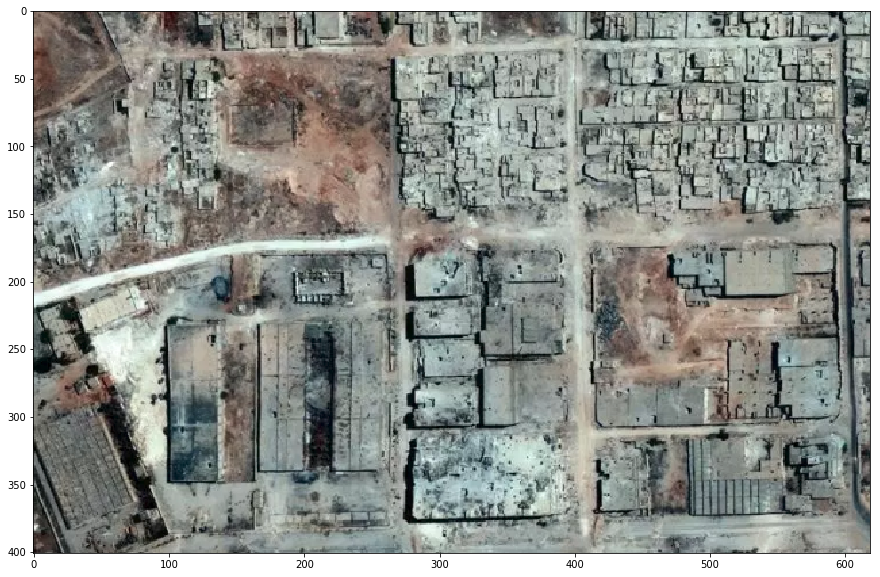

In [69]:
tr = np.array(Image.open(test[1]))# [:256, -256:]# [70:326, 320:576]
plt.figure(figsize=(15, 15))
plt.imshow(tr)
plt.show()

In [28]:
# f = np.random.choice(test)
# img = np.array(Image.open(f))
# random_x = np.random.randint(0, 1500-img_size)
# random_y = np.random.randint(0, 1500-img_size)
# ftruth = f.replace('images', 'labels')
# ftruth = ftruth[:-1]
# crop = img[random_x: random_x+img_size, random_y:random_y+img_size]
# truth =np.array(Image.open(ftruth))[random_x:random_x+img_size, random_y:random_y+img_size, 0]

In [29]:
# out = model.predict(np.expand_dims(crop, axis=0))

In [30]:
# plt.figure()
# f, ax = plt.subplots(1, 3, figsize=(20, 10))
# ax[0].imshow(crop)
# ax[1].imshow(truth)
# ax[2].imshow(out[0,...,0])

In [61]:
out = model.predict(np.expand_dims(tr, axis=0))

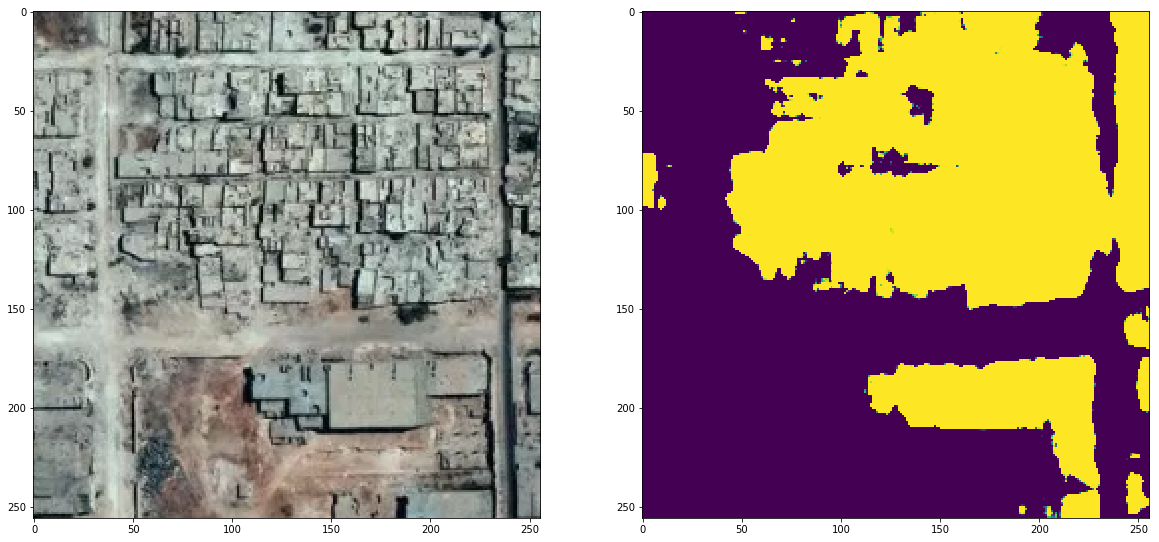

In [62]:
plt.figure()
f, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(tr)
ax[1].imshow(out[0,...,0])

In [63]:
import copy

In [64]:
img = Image.fromarray(tr)
mask = np.zeros((256, 256, 3), dtype=np.uint8)
tmp = copy.deepcopy(out[0,...,0])
tmp[tmp>0.1] = 255
mask[:,:,0] = tmp
mask = Image.fromarray(mask)
new = Image.blend(img, mask, 0.5)

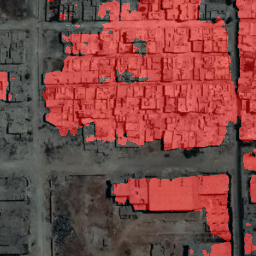

In [65]:
new

In [66]:
new.save('/root/thomas/github/stanfordHacks/syria_after.png')

In [ ]:
mask.size
img.size

In [ ]:
new.save('/root/thomas/github/stanfordHacks/results.png')

In [ ]:
# tru = test[0,...]

In [ ]:
# tru[tru>0.5] = 1

In [ ]:
# import matplotlib.pyplot as plt

In [ ]:
# plt.